In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class CustomContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin  # how far apart the dissimilar pairs should be pushed

    def forward(self, features, targets):
        positive_dist = torch.norm(features - targets, p=2, dim=1)

        # Euclidean distances for negative pairs and apply margin
        # For each target, calculate its distance to all other features and targets
        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    # Distance from target i to features j
                    dist_to_features = torch.norm(targets[i] - features[j], p=2)
                    # Distance from target i to targets j
                    dist_to_targets = torch.norm(targets[i] - targets[j], p=2)
                    # Apply margin and accumulate repulsion loss
                    repulsion_loss += F.relu(self.margin - dist_to_features) + F.relu(self.margin - dist_to_targets)

        # Mean over all pairs for both attraction and repulsion components
        attraction_loss = positive_dist.mean()
        repulsion_loss /= (batch_size * (batch_size - 1) * 2)  # Normalize by number of negative pairs

        # Total loss: minimize attraction while maximizing repulsion
        total_loss = attraction_loss + repulsion_loss

        return total_loss

In [4]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    print(features.shape)
    print(targets.shape)
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset

In [5]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [6]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), train_size = 5, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [7]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 512
hidden_dim_target = 24
output_dim = 2
num_epochs = 1000


In [8]:
def gaussian_kernel(x, krnl_sigma = 1.):
    x1 = x[:, :1] - x[:, :1].T
    x2 = x[:, 1:2] - x[:, 1:2].T
    x = x1**2 + x2**2
    return torch.exp(-x / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*1)

def cauchy(x, krnl_sigma=0.3):
    x1 = x[:, :1] - x[:, :1].T
    x2 = x[:, 1:2] - x[:, 1:2].T
    x = x1**2 + x2**2
    return 1. / (krnl_sigma*x + 1)

def rbf(x, krnl_sigma=0.3):
    x1 = x[:, :1] - x[:, :1].T
    x2 = x[:, 1:2] - x[:, 1:2].T
    x = x1**2 + x2**2
    return torch.exp(-x/(2*(krnl_sigma**2)))

In [9]:
temperature = 0.5
base_temperature = 0.5 # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 3 # too low values return nan loss

In [10]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([5, 499500])
torch.Size([5, 59])
torch.Size([142, 499500])
torch.Size([142, 59])


In [19]:

model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
# criterion = KernelizedSupCon(method='expw', temperature=temperature, base_temperature=base_temperature, kernel=kernel, delta_reduction = 'mean')
criterion = CustomContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion(out_feat, out_target)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 1.188398838043213
Epoch 1 | Mean Loss 0.9712313115596771
Epoch 2 | Mean Loss 1.0958621501922607
Epoch 3 | Mean Loss 1.0191331803798676
Epoch 4 | Mean Loss 1.3921197652816772
Epoch 5 | Mean Loss 0.9543524384498596
Epoch 6 | Mean Loss 0.5277063548564911
Epoch 7 | Mean Loss 0.793696254491806
Epoch 8 | Mean Loss 0.8144688904285431
Epoch 9 | Mean Loss 0.9005146026611328
Epoch 10 | Mean Loss 0.36498235166072845
Epoch 11 | Mean Loss 0.8244892656803131
Epoch 12 | Mean Loss 0.7574219703674316
Epoch 13 | Mean Loss 0.4940088503062725
Epoch 14 | Mean Loss 0.4694426506757736
Epoch 15 | Mean Loss 1.2278952300548553
Epoch 16 | Mean Loss 0.5191743522882462
Epoch 17 | Mean Loss 0.47545239329338074
Epoch 18 | Mean Loss 0.4342959523200989
Epoch 19 | Mean Loss 0.4545346051454544
Epoch 20 | Mean Loss 0.3629850447177887
Epoch 21 | Mean Loss 1.0287171006202698
Epoch 22 | Mean Loss 0.3700205162167549
Epoch 23 | Mean Loss 0.47560447454452515
Epoch 24 | Mean Loss 0.3235246017575264
Epoch 25 

Epoch 200 | Mean Loss 0.1747889593243599
Epoch 201 | Mean Loss 0.0401028236374259
Epoch 202 | Mean Loss 0.2506377100944519
Epoch 203 | Mean Loss 0.09035661816596985
Epoch 204 | Mean Loss 0.2515469416975975
Epoch 205 | Mean Loss 0.05453135445713997
Epoch 206 | Mean Loss 0.13185610622167587
Epoch 207 | Mean Loss 0.17852961272001266
Epoch 208 | Mean Loss 0.1411958783864975
Epoch 209 | Mean Loss 0.12448333576321602
Epoch 210 | Mean Loss 0.09704351425170898
Epoch 211 | Mean Loss 0.051999712362885475
Epoch 212 | Mean Loss 0.20115134119987488
Epoch 213 | Mean Loss 0.08275983668863773
Epoch 214 | Mean Loss 0.1795753762125969
Epoch 215 | Mean Loss 0.07968202047049999
Epoch 216 | Mean Loss 0.03804348409175873
Epoch 217 | Mean Loss 0.15263186395168304
Epoch 218 | Mean Loss 0.09727435931563377
Epoch 219 | Mean Loss 0.12940924614667892
Epoch 220 | Mean Loss 0.06947623752057552
Epoch 221 | Mean Loss 0.05609592655673623
Epoch 222 | Mean Loss 0.045535609126091
Epoch 223 | Mean Loss 0.11682769283652306

Epoch 397 | Mean Loss 0.09126267954707146
Epoch 398 | Mean Loss 0.09542842954397202
Epoch 399 | Mean Loss 0.07359415851533413
Epoch 400 | Mean Loss 0.11501498520374298
Epoch 401 | Mean Loss 0.1150284893810749
Epoch 402 | Mean Loss 0.032555882818996906
Epoch 403 | Mean Loss 0.037327864207327366
Epoch 404 | Mean Loss 0.1422373130917549
Epoch 405 | Mean Loss 0.05645022913813591
Epoch 406 | Mean Loss 0.12217020243406296
Epoch 407 | Mean Loss 0.09244616329669952
Epoch 408 | Mean Loss 0.08376891911029816
Epoch 409 | Mean Loss 0.08132621832191944
Epoch 410 | Mean Loss 0.09011627547442913
Epoch 411 | Mean Loss 0.08989521861076355
Epoch 412 | Mean Loss 0.06999402865767479
Epoch 413 | Mean Loss 0.07043726742267609
Epoch 414 | Mean Loss 0.09601383283734322
Epoch 415 | Mean Loss 0.14170628786087036
Epoch 416 | Mean Loss 0.11721812002360821
Epoch 417 | Mean Loss 0.08790835924446583
Epoch 418 | Mean Loss 0.06157359294593334
Epoch 419 | Mean Loss 0.1428723894059658
Epoch 420 | Mean Loss 0.12670526001

Epoch 593 | Mean Loss 0.08048813417553902
Epoch 594 | Mean Loss 0.08503790944814682
Epoch 595 | Mean Loss 0.06844744272530079
Epoch 596 | Mean Loss 0.06580295786261559
Epoch 597 | Mean Loss 0.09454655088484287
Epoch 598 | Mean Loss 0.16665459051728249
Epoch 599 | Mean Loss 0.1589706353843212
Epoch 600 | Mean Loss 0.06514370255172253
Epoch 601 | Mean Loss 0.08280323818325996
Epoch 602 | Mean Loss 0.050133056938648224
Epoch 603 | Mean Loss 0.183439202606678
Epoch 604 | Mean Loss 0.04797614365816116
Epoch 605 | Mean Loss 0.12101173400878906
Epoch 606 | Mean Loss 0.10493489354848862
Epoch 607 | Mean Loss 0.09857805445790291
Epoch 608 | Mean Loss 0.04040056373924017
Epoch 609 | Mean Loss 0.05790541134774685
Epoch 610 | Mean Loss 0.06195936072617769
Epoch 611 | Mean Loss 0.05988991633057594
Epoch 612 | Mean Loss 0.06919144839048386
Epoch 613 | Mean Loss 0.05424268823117018
Epoch 614 | Mean Loss 0.06037595868110657
Epoch 615 | Mean Loss 0.05017691291868687
Epoch 616 | Mean Loss 0.072929859161

Epoch 788 | Mean Loss 0.05335672199726105
Epoch 789 | Mean Loss 0.04091713856905699
Epoch 790 | Mean Loss 0.051066718995571136
Epoch 791 | Mean Loss 0.03920640982687473
Epoch 792 | Mean Loss 0.035282960161566734
Epoch 793 | Mean Loss 0.06695777643471956
Epoch 794 | Mean Loss 0.02282677497714758
Epoch 795 | Mean Loss 0.043721169233322144
Epoch 796 | Mean Loss 0.035405516624450684
Epoch 797 | Mean Loss 0.07634913548827171
Epoch 798 | Mean Loss 0.05059593915939331
Epoch 799 | Mean Loss 0.058396121487021446
Epoch 800 | Mean Loss 0.07542041316628456
Epoch 801 | Mean Loss 0.10299859568476677
Epoch 802 | Mean Loss 0.01309005543589592
Epoch 803 | Mean Loss 0.16504826862365007
Epoch 804 | Mean Loss 0.09595765173435211
Epoch 805 | Mean Loss 0.07728566229343414
Epoch 806 | Mean Loss 0.13881339319050312
Epoch 807 | Mean Loss 0.04424189403653145
Epoch 808 | Mean Loss 0.12311528250575066
Epoch 809 | Mean Loss 0.04919054452329874
Epoch 810 | Mean Loss 0.08519625198096037
Epoch 811 | Mean Loss 0.05681

Epoch 983 | Mean Loss 0.053404709324240685
Epoch 984 | Mean Loss 0.05638451501727104
Epoch 985 | Mean Loss 0.047577342949807644
Epoch 986 | Mean Loss 0.034366216510534286
Epoch 987 | Mean Loss 0.0675329715013504
Epoch 988 | Mean Loss 0.08801201544702053
Epoch 989 | Mean Loss 0.07097163610160351
Epoch 990 | Mean Loss 0.031897484324872494
Epoch 991 | Mean Loss 0.025030705612152815
Epoch 992 | Mean Loss 0.02452187007293105
Epoch 993 | Mean Loss 0.11566527187824249
Epoch 994 | Mean Loss 0.06549539044499397
Epoch 995 | Mean Loss 0.07926992699503899
Epoch 996 | Mean Loss 0.017409663181751966
Epoch 997 | Mean Loss 0.07000168785452843
Epoch 998 | Mean Loss 0.024154595099389553
Epoch 999 | Mean Loss 0.07391780614852905
Training target estimator


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-package

Training target estimator


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-package

0.20034303 0.981304546837015


In [35]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [12]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [20]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   0.22


In [21]:
emb_features = torch.row_stack(emb_features)

In [22]:
emb_targets = torch.row_stack(emb_targets)

In [32]:
criterion = KernelizedSupCon(method='expw', temperature=0.05, base_temperature=0.05, kernel=gaussian_kernel)
criterion(emb_features, emb_targets)

AttributeError: 'DataFrame' object has no attribute 'device'

In [16]:
emb_features

tensor([[-0.1697,  0.9855],
        [ 0.5086,  0.8610],
        [-0.1914,  0.9815],
        [-0.0052,  1.0000],
        [ 0.5134,  0.8581]])

In [17]:
emb_targets

tensor([[ 0.2939, -0.9558],
        [-0.9649,  0.2627],
        [ 0.9342, -0.3568],
        [ 0.6984, -0.7157],
        [ 0.0246, -0.9997]])

In [27]:
emb_targets = emb_features

In [23]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [24]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [25]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


In [43]:
emb_targets = emb_features

In [30]:
emb_targets

tensor([[-0.0052,  1.0000],
        [-0.1914,  0.9815],
        [ 0.5086,  0.8610],
        [-0.1697,  0.9855],
        [ 0.5134,  0.8581]])

In [292]:
# emb_targets = emb_features

In [31]:
#criterion = KernelizedSupCon(method='expw', temperature=0.05, base_temperature=0.05, kernel=gaussian_kernel)

criterion(emb_features, emb_targets)

tensor(2.2963)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

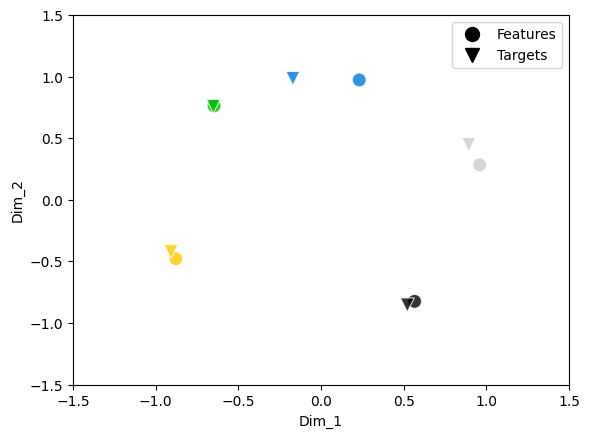

In [26]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])

## Learning curve

In [27]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)


In [28]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [29]:
estimator = TargetEstimator()

In [30]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


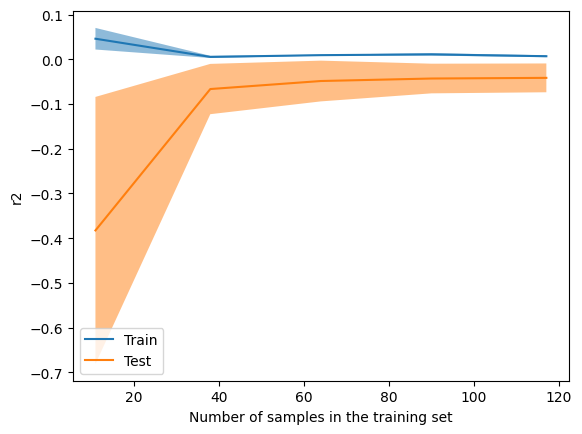

In [31]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
